**Demo: Prostate Cancer Analysis with LASSO and Other Feature Selection Methods**


Fitting a LASSO model on prostate cancer dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Loading the Data

In [2]:
url = 'https://web.stanford.edu/~hastie/ElemStatLearn/datasets/prostate.data'
df = pd.read_csv(url, sep='\t', header=0)
df = df.drop('Unnamed: 0', axis=1)

In the dataset, the target variable is log(PSA), i.e. lpsa

In [3]:
names = df.columns.tolist()
names_x = names[0:7]
name_y = names[8]
print("Target variable: %s" % name_y)
print("Predictors: "+str(names_x))

# Convert the dataframe values to data matrices
X0 = np.array(df[names_x])
y0 = np.array(df[name_y])

# Print the number of samples and features
nsamp = X0.shape[0]
nfeatures = X0.shape[1]
print("")
print("num samples = %d,  num features = %d" % (nsamp, nfeatures))

Target variable: lpsa
Predictors: ['lcavol', 'lweight', 'age', 'lbph', 'svi', 'lcp', 'gleason']

num samples = 97,  num features = 7


Using sklearn built in scale command to standardize values

In [4]:
import sklearn.preprocessing

X = sklearn.preprocessing.scale(X0)
y = sklearn.preprocessing.scale(y0)

**Fitting a Linear Model with no regularization**

In [5]:
from sklearn import linear_model
from sklearn.model_selection import train_test_split

Splitting the dataset

In [6]:
X_tr, X_ts, y_tr, y_ts = train_test_split(X,y,test_size=0.5,shuffle=True)
ntr = X_tr.shape[0]
nts = X_ts.shape[0]
print("num samples train = %d, test = %d" % (ntr, nts))

num samples train = 48, test = 49


Fitting the model on training data

In [7]:
regr = linear_model.LinearRegression()
regr.fit(X_tr,y_tr)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

Measuring normalized RSS

In [8]:
y_tr_pred = regr.predict(X_tr)
rsq_tr = 1-np.mean((y_tr_pred-y_tr)**2)/(np.std(y_tr)**2)
print("R^2 training = %f" % rsq_tr)

R^2 training = 0.620784


Evaluating model on test data

In [9]:
y_ts_pred = regr.predict(X_ts)
rss_ts = np.mean((y_ts_pred-y_ts)**2)/(np.std(y_ts)**2)
rsq_ts = 1-rss_ts
print("Normalized test RSS = %f" % rss_ts)
print("Normalized test R^2 = %f" % rsq_ts)

Normalized test RSS = 0.406223
Normalized test R^2 = 0.593777


Plotting actual v/s predicted values

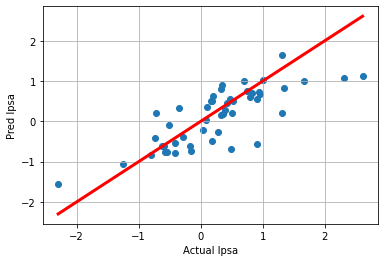

In [10]:
plt.scatter(y_ts,y_ts_pred)
plt.xlabel('Actual lpsa')
plt.ylabel('Pred lpsa')
ymin = np.min(y_ts)
ymax = np.max(y_ts)
plt.plot([ymin,ymax], [ymin,ymax], 'r-', linewidth=3)
plt.grid()
plt.show()

Plotting coefficients in the regression model

    lcavol    0.5393
   lweight    0.3146
       age   -0.1987
      lbph    0.0902
       svi    0.2228
       lcp   -0.0310
   gleason    0.0367


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  """


<StemContainer object of 3 artists>

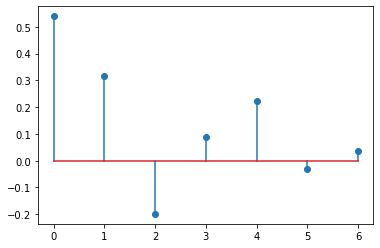

In [11]:
w = regr.coef_
for name, wi in zip(names_x, w):
    print('%10s %9.4f' % (name, wi))
    
plt.stem(w)

LASSO: Linear Model with L1 Regularization

In [12]:
import  sklearn.model_selection

Finding regularization level alpha

In [13]:
nfold = 10
kf = sklearn.model_selection.KFold(n_splits=nfold,shuffle=True)

# Regularization values to test
nalpha = 100
alphas = np.logspace(-3,1,nalpha)

# MSE for each alpha and fold value
mse = np.zeros((nalpha,nfold))
for ifold, ind in enumerate(kf.split(X)):
        
    # Get the training data in the split
    Itr,Its = ind
    X_tr = X[Itr,:]
    y_tr = y[Itr]
    X_ts = X[Its,:]
    y_ts = y[Its]
    
    # Compute the lasso path for the split
    for ia, a in enumerate(alphas):
        
        # Create a LASSO model object
        model = linear_model.Lasso(alpha=a)
        
        # Fit the model on the training data
        model.fit(X_tr,y_tr)
        
        # Compute the prediction error on the test data
        y_ts_pred = model.predict(X_ts)
        mse[ia,ifold] = np.mean((y_ts_pred-y_ts)**2)

Plotting MSE v/s alpha

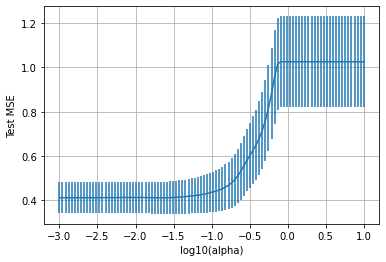

In [14]:
mse_mean = np.mean(mse,axis=1)
mse_se = np.std(mse,axis=1) / np.sqrt(nfold-1)

# Plot the mean MSE and the mean MSE with 1 SE error bars
plt.errorbar(np.log10(alphas), mse_mean, yerr=mse_se)
plt.xlabel('log10(alpha)')
plt.ylabel('Test MSE')
plt.grid()
plt.show()

Finding optimal alpha using one SE rule

Optimal alpha = 0.183074


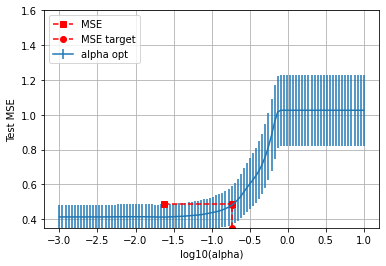

In [15]:
imin = np.argmin(mse_mean)
mse_tgt = mse_mean[imin] + mse_se[imin]
alpha_min = alphas[imin]

# Find the least complex model with mse_mean < mse_tgt
I = np.where(mse_mean < mse_tgt)[0]
iopt = I[-1]
alpha_opt = alphas[iopt]
print("Optimal alpha = %f" % alpha_opt)

# Plot the mean MSE and the mean MSE + 1 SE errorbars 
plt.errorbar(np.log10(alphas), mse_mean, yerr=mse_se)

# Plot the MSE target
amin_log = np.log10(alpha_min)
aopt_log = np.log10(alpha_opt)
plt.plot([amin_log,aopt_log], [mse_tgt,mse_tgt], 'rs--')

# Plot the optimal alpha line
plt.plot([aopt_log,aopt_log], [0.35,mse_mean[iopt]], 'ro--')

plt.legend(['MSE', 'MSE target','alpha opt'],loc='upper left')
plt.xlabel('log10(alpha)')
plt.ylabel('Test MSE')
plt.ylim([0.35,1.6])
plt.grid()
plt.show()

Recomputing coefficients using the optimal alpha

In [16]:
model.alpha = alpha_opt
model.fit(X,y)

# Print the coefficients
for i, c in enumerate(model.coef_):
    print("%8s %f" % (names_x[i], c))


  lcavol 0.457465
 lweight 0.103180
     age 0.000000
    lbph 0.000000
     svi 0.120609
     lcp 0.000000
 gleason 0.000000


Using the above the features to determine mean regression coefficients

In [18]:
Isel = np.where(np.abs(model.coef_) > 1e-3)[0]


# Select those features
X1=X[:,Isel]
nfea1 = len(Isel)

# Run 10-fold validation with reduced feature matrix
nfold = 10
kf = sklearn.model_selection.KFold(n_splits=nfold,shuffle=True)

# MSE for each alpha and fold value
RSS_ts = np.zeros((nfold,1))
coef=np.zeros((nfold,nfea1))
for ifold, ind in enumerate(kf.split(X1)):
    
    
    # Get the training data in the split
    Itr,Its = ind
    X_tr = X1[Itr,:]
    y_tr = y[Itr]
    X_ts = X1[Its,:]
    y_ts = y[Its]
    
    regr.fit(X_tr,y_tr)
    y_ts_pred = regr.predict(X_ts)
    RSS_ts[ifold] = np.mean((y_ts_pred-y_ts)**2)/(np.std(y_ts)**2)
    coef[ifold]=regr.coef_
            
mse_mean = np.mean(RSS_ts,axis=0)
mse_se = np.std(RSS_ts,axis=0) / np.sqrt(nfold-1)
coef_mean=np.mean(coef,axis=0)
print("mse_mean=%f, mse_SE=%f" % (mse_mean, mse_se))
print(coef_mean)

mse_mean=0.601123, mse_SE=0.157180
[0.53729396 0.24555926 0.23859117]


**LASSO Path**

Plot of coefficients as a function of regularization alpha

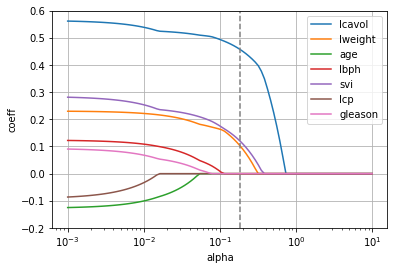

In [19]:
alphas1, coeffs, _ = sklearn.linear_model.lasso_path(X, y, alphas=alphas)

# Plot the paths of the coefficients
plt.semilogx(alphas1,coeffs.T)
plt.grid()
plt.legend(names_x, loc='upper right')


# Plot a line on the optimal alpha
plt.semilogx([alpha_opt,alpha_opt], [-0.2,0.6], '--')
plt.ylim([-0.2,0.6])
plt.xlabel('alpha')
plt.ylabel('coeff')
plt.show()